<a href="https://colab.research.google.com/github/renaaliu/classifying_opioid_documents/blob/main/held_out_test_v5_title_classification_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set up
This imports all the libraries and packages (torch, numpy, pandas, etc.)

In [ ]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, f1_score, average_precision_score, recall_score

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

import numpy as np

from numpy import genfromtxt

import matplotlib.pyplot as plt

import pandas as pd

In [ ]:
# Configure HuggingFace
!pip install transformers

import transformers
# from transformers import pipeline

# !pip install transformers[sentencepiece]

import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizerFast

import torch.optim as optim

from torch.utils.data import DataLoader
from transformers import DistilBertForSequenceClassification, AdamW

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Input: Format and Encode 

#### Label Pre-processing
This pulls and opens the encoded_labeled_ocrs.csv (creation explained above) which holds the encoded file samples (input_ids and attention_mask) and corresponding numerical document type labels. The data within this file is then converted into arrays of Floats. The input_ids and labels are then formatted and batched.

In [ ]:
# STEP 1: Uploaded encoded_labeled_ocrs.csv document (created using file_pre_processing.ipynb)
csv_path = '/content/encoded_labeled_ocrs.csv'
csv_data = pd.read_csv(csv_path)

In [ ]:
# The data within this file is then converted into arrays of Floats.
input_ids_col = []
attention_mask_col = []
new_labels = []
new_encodings = {}
input_len = 512
for index, row in csv_data.iterrows():
    # Manually converts string of '[x, y, z]' to float array [x, y, z] where x,y,z are floats
    input_ids = row['Encoding_input_id'][1:]
    input_ids = input_ids[:-1]
    input_ids = input_ids.split(', ')
    # converts from string to float
    input_ids = np.array([float(entity) for entity in input_ids])
    if len(input_ids) < input_len:
      for i in range(input_len - len(input_ids)):
        input_ids = np.pad(input_ids, [(0, 1)])

    attention_masks = row['Encoding_attention_mask'][1:]
    attention_masks = attention_masks[:-1]
    attention_masks = attention_masks.split(', ')
    attention_masks = np.array([float(entity) for entity in attention_masks])
    if len(attention_masks) < input_len:
      for i in range(input_len - len(attention_masks)):
        attention_masks = np.pad(attention_masks, [(0, 1)])

    ## Create arrays: dataset where each row is [id, mask, label], 
    ## input_ids_col where each row is id,
    ## attention_mask_col where each row is attention_mask,
    ## train_labels where each row is a label
    
    ## Top modes are 10, 19, 12, 23, 7
    ## if row['Label'] == 10 or row['Label'] == 19 or row['Label'] == 12 or row['Label'] == 23 or row['Label'] == 7:
    if row['Label'] == 19:
      row['Label'] = 1
    else:
      row['Label'] = 0
    
    input_ids_col.append(input_ids)
    attention_mask_col.append(attention_masks)
    new_labels.append(row['Label'])

In [ ]:
dataset = {}
dataset['input_ids'] = input_ids_col
dataset.update({'attention_mask': attention_mask_col})
dataset.update({'labels': new_labels})
dataset = pd.DataFrame(dataset)

In [ ]:
# Splitting into Train and Test
k_proportion_of_test_set = 0.8

train_rows = dataset.sample(frac=k_proportion_of_test_set, random_state=25)
test_rows = dataset.drop(train_rows.index)

In [ ]:
train_encodings = {}
train_encodings['input_ids'] = train_rows['input_ids'].tolist()
train_encodings.update({'attention_mask': train_rows['attention_mask'].tolist()})
train_labels = train_rows['labels'].tolist()

test_encodings = {}
test_encodings['input_ids'] = test_rows['input_ids'].tolist()
test_encodings.update({'attention_mask': test_rows['attention_mask'].tolist()})
test_labels = test_rows['labels'].tolist()

In [ ]:
# The input_ids and labels are then formatted and batched.
class EncodedFilesDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = EncodedFilesDataset(train_encodings, train_labels)
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_dataset = EncodedFilesDataset(test_encodings, test_labels)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size = 5)

#####Plotting Label Distribution

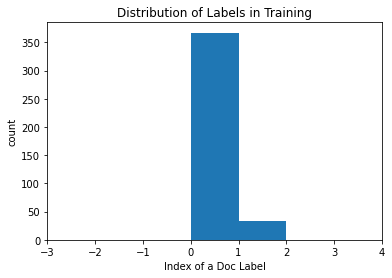

(idx == 1)/total: 0.0825
(idx == 0)/total: 0.9175


In [ ]:
# # Plot of Disitrubtion of Labels in Training
data = train_labels
bins = np.arange(0, 60, 1) # fixed bin size

plt.xlim([min(data)-3, max(data)+3])

plt.hist(data, bins=bins)
plt.title('Distribution of Labels in Training')
plt.xlabel('Index of a Doc Label')
plt.ylabel('count')

plt.show()

print('(idx == 1)/total:',data.count(1)/len(data))
print('(idx == 0)/total:',data.count(0)/len(data))

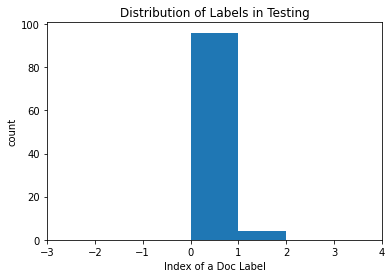

(idx == 1)/total: 0.04
(idx == 0)/total: 0.96


In [ ]:
# # Plot of Disitrubtion of Labels in Testing
data = test_labels
bins = np.arange(0, 60, 1) # fixed bin size

plt.xlim([min(data)-3, max(data)+3])

plt.hist(data, bins=bins)
plt.title('Distribution of Labels in Testing')
plt.xlabel('Index of a Doc Label')
plt.ylabel('count')

plt.show()

print('(idx == 1)/total:',data.count(1)/len(data))
print('(idx == 0)/total:',data.count(0)/len(data))

## Defining the linear NN
This section defines the Net class for the neural network. This is based on a Pytorch tutorial and many lines are commented out but kept to give context of the possibilities of nonlinear and otherwise more complicated models.

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # # self.conv1 = nn.Conv2d(3, 6, 5)
        # # self.pool = nn.MaxPool2d(2, 2)
        # # self.conv2 = nn.Conv2d(6, 16, 5)
        # self.fc1 = nn.Linear(3, 120)
        # self.fc2 = nn.Linear(120, 84)
        # # self.fc3 = nn.Linear(84, 8)
        # self.fc3 = nn.Linear(84, 3)

        # self.fc1 = nn.Linear(3, 60)
        # self.fc2 = nn.Linear(60, 42)
        # self.fc3 = nn.Linear(42, 3)

        ### self.fc1 = nn.Linear(512, 120)
        self.fc1 = nn.Linear(512, 480)
        # self.fc1 = nn.Linear(train_tokenizer_output_size, 120)
        ### self.fc2 = nn.Linear(120, 84)
        self.fc2 = nn.Linear(480, 336)
        ### self.fc3 = nn.Linear(84, 57)
        self.fc3 = nn.Linear(336, 57)
        # self.fc3 = nn.Linear(84, 3)

        # self.dropout = nn.Dropout(0.25)
        # self.bn = torch.nn.BatchNorm2d(32)

    def forward(self, x):
        # x = self.pool(F.relu(self.conv1(x)))
        # x = self.pool(F.relu(self.conv2(x)))
        # x = torch.flatten(x, 1) # flatten all dimensions except batch
        # print(x)
        a = self.fc1(x)
        x = F.relu(a)
        # x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

## Define a Loss function and optimize
This section sets the loss to be Cross Entropy Loss and the optimizer to be from Adam.

In [ ]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
optimizer = AdamW(net.parameters(), lr=5e-3)
# optimizer = AdamW(net.parameters(), lr=5e-30)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


## Train Network
https://androidkt.com/calculate-total-loss-and-accuracy-at-every-epoch-and-plot-using-matplotlib-in-pytorch/

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# For computing accuracy
# https://androidkt.com/calculate-total-loss-and-accuracy-at-every-epoch-and-plot-using-matplotlib-in-pytorch/
train_correct, train_total = 0, 0
train_losses = []
train_accu = []

epochs = range(100)
running_loss = []

for epoch in epochs:
    for train_batch in train_loader:
        input_ids = train_batch['input_ids'].to(device)
        inputs = torch.tensor(input_ids)
        # attention_mask = batch['attention_mask'].to(device)
        labels = train_batch['labels'].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # outputs is the NN model
        outputs = net(inputs.type(torch.float32))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Compute Accuracy            
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()
              
        # train_loss = running_loss/len(train_loader)
        accu = 100.*train_correct/train_total
        
        # create and append to list of accuracies and loss
        train_accu.append(accu)
        running_loss.append(loss.detach())

        # # Print Prediction, True Label, Loss & Accuracy per Epoch
        # print("Prediction", predicted)
        # print("True Label", labels)
        # print('Train Loss: %.3f | Accuracy: %.3f'%(loss,accu))
        # print()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


## Evaluation Metrics

In [ ]:
def tf_count(t, val):
    elements_equal_to_value = tf.equal(t, val)
    as_ints = tf.cast(elements_equal_to_value, tf.int32)
    count = tf.reduce_sum(as_ints)
    return count

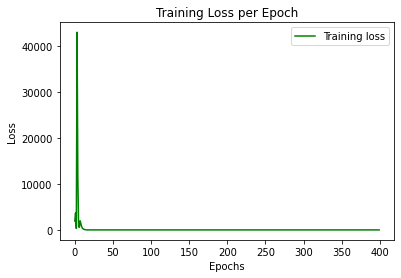

Final Loss: tensor(0.2489)


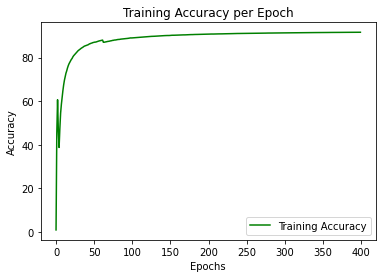

Final Accuracy: 91.6275


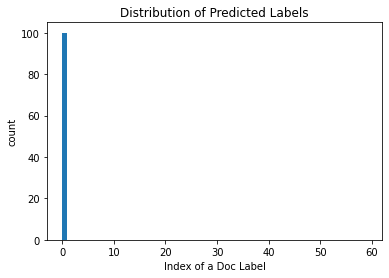

Prediction Class Distribution
(idx == 1)/100: tf.Tensor(0.0, shape=(), dtype=float64)
(idx == 0)/100: tf.Tensor(1.0, shape=(), dtype=float64)


Net(
  (fc1): Linear(in_features=512, out_features=480, bias=True)
  (fc2): Linear(in_features=480, out_features=336, bias=True)
  (fc3): Linear(in_features=336, out_features=57, bias=True)
)

In [ ]:
# Graph Loss per Epoch
# print(running_loss)
plt.plot(range(len(epochs)*len(train_loader)), running_loss, 'g', label='Training loss')
#plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
print("Final Loss:", running_loss[-1])

# Graph Train Acc per Epoch
plt.plot(range(len(epochs)*len(train_loader)), train_accu, 'g', label='Training Accuracy')
#plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
print("Final Accuracy:", train_accu[-1])

# Graph Test Accuracy per Epoch
# plt.plot(range(len(epochs)*len(test_loader)), test_accu_array, 'g', label='Test Accuracy')
# plt.title('Test Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

# Plot distribution of predictions
data = predicted
bins = np.arange(0, 60, 1) # fixed bin size
plt.hist(data, bins=bins)
plt.title('Distribution of Predicted Labels')
plt.xlabel('Index of a Doc Label')
plt.ylabel('count')
plt.show()
print('Prediction Class Distribution')
print('(idx == 1)/100:',tf_count(data,1)/len(data))
print('(idx == 0)/100:',tf_count(data,0)/len(data))

net.eval()

### ROC Area Under the Curve and F1 Score

In [ ]:
y_true = labels
y_pred = predicted
print('ScikitLearn Accuracy', accuracy_score(y_true, y_pred))
print('F1 Score', f1_score(y_true, y_pred))
print('ROC AUC', roc_auc_score(y_true, y_pred))
print('Precision', average_precision_score(y_true, y_pred))
print('Recall', recall_score(y_true, y_pred))

ScikitLearn Accuracy 0.9
F1 Score 0.0
ROC AUC 0.5
Precision 0.1
Recall 0.0


### Held out testing 
https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-k-fold-cross-validation-with-pytorch.md 

In [ ]:
correct, total = 0, 0
test_accu = []

epochs = range(30)
running_loss = []

for epoch in epochs:
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        inputs = torch.tensor(input_ids)
        labels = batch['labels'].to(device)

        # Generate outputs
        outputs = net(inputs.type(torch.float32))

        # Set total and correct
        _, predicted = outputs.max(1)
        total += labels.size(0)
        # correct += (predicted == labels).sum().item()
        correct += predicted.eq(labels).sum().item()

        loss = criterion(outputs, labels)
        running_loss.append(loss.detach())

        accu = 100.*correct/total
        test_accu.append(accu)

        # # Print Prediction, True Label, Loss & Accuracy per Epoch
        # print("Prediction", predicted)
        # print("True Label", labels)
        # print('Train Loss: %.3f | Accuracy: %.3f'%(loss,accu))
        # print()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


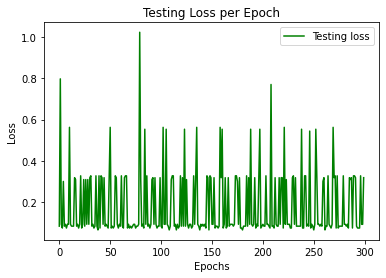

Final Loss: tensor(0.3177)


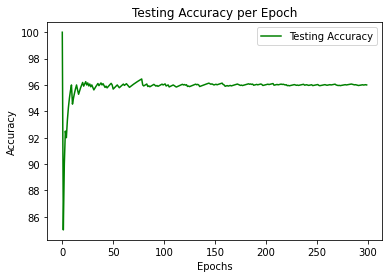

Final Accuracy: 96.0


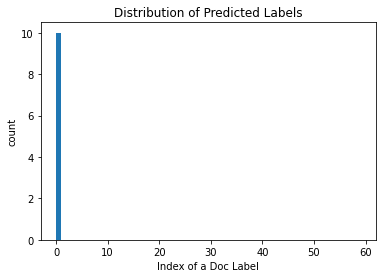

Prediction Class Distribution
(idx == 1)/100: tf.Tensor(0.0, shape=(), dtype=float64)
(idx == 0)/100: tf.Tensor(1.0, shape=(), dtype=float64)


In [ ]:
# Graph Loss per Epoch
# print(running_loss)
plt.plot(range(len(epochs)*len(test_loader)), running_loss, 'g', label='Testing loss')
#plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Testing Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
print("Final Loss:", running_loss[-1])

# Graph Testing Acc per Epoch
plt.plot(range(len(epochs)*len(test_loader)), test_accu, 'g', label='Testing Accuracy')
#plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Testing Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
print("Final Accuracy:", test_accu[-1])

# # Plot distribution of predictions
data = predicted
bins = np.arange(0, 60, 1) # fixed bin size
plt.hist(data, bins=bins)
plt.title('Distribution of Predicted Labels')
plt.xlabel('Index of a Doc Label')
plt.ylabel('count')
plt.show()
print('Prediction Class Distribution')
print('(idx == 1)/100:',tf_count(data,1)/len(data))
print('(idx == 0)/100:',tf_count(data,0)/len(data))

In [ ]:
y_true = labels
y_pred = predicted
print('ScikitLearn Accuracy', accuracy_score(y_true, y_pred))
print('F1 Score', f1_score(y_true, y_pred))
print('ROC AUC', roc_auc_score(y_true, y_pred))
print('Precision', average_precision_score(y_true, y_pred))
print('Recall', recall_score(y_true, y_pred))

ScikitLearn Accuracy 0.9
F1 Score 0.0
ROC AUC 0.5
Precision 0.1
Recall 0.0
